# Evolutionary Algorithm
for cutting stock problem

In [2]:
import pandas as pd
import numpy as np
import random
import math
from matplotlib import pyplot as plt

In [4]:
r800 = pd.read_csv('data/cutting/r800.csv', names=['width','height','val'])
r850 = pd.read_csv('data/cutting/r850.csv', names=['width','height','val'])
r1000 = pd.read_csv('data/cutting/r1000.csv', names=['width','height','val'])
r1100 = pd.read_csv('data/cutting/r1100.csv', names=['width','height','val'])
r1200 = pd.read_csv('data/cutting/r1200.csv', names=['width','height','val'])

In [5]:
full_dfs = []
for df in [r800, r850, r1000, r1100, r1200]:
    tmp = df.copy()
    tmp = df[['height', 'width', 'val']]
    tmp.columns = ['width', 'height', 'val']
    df = pd.concat([df, tmp], ignore_index=True)
    full_dfs.append(df)

### Population

In [6]:
def create_genome(data, d, length):
    full_genome = np.random.randint(0, len(data), length)
    return full_genome[data.values[:,0][full_genome].cumsum() < d]

def create_population(data, d, n):
    cols_lower_bound = np.ceil(d / np.max(data.values))
    cols_upper_bound = np.ceil(d / np.min(data.values))
    length = random.randint(cols_lower_bound, cols_upper_bound+1)
    return [create_genome(data, d, length) for i in range(n)]

### Fitness

In [7]:
def maximum_height(x, r):
    mask = x > 2 * r
    result = np.zeros_like(x)
    result[mask] = 0
    result[~mask] = 2 * np.sqrt(r[~mask]**2 - (r[~mask]-x[~mask])**2)
    return result

def n_rectangles(column_height, height):
    return np.floor(column_height / height)

In [8]:
def fitness(population, data, r):
    results = np.zeros(len(population))
    for i, gen in enumerate(population):
        x = data.values[:,0][gen]
        y = data.values[:,1][gen]
        val = data.values[:,2][gen]

        start = r - np.sqrt(r**2 - (y[0]/2) ** 2)
        breaks = np.concatenate(([start], np.cumsum(x))) 

        maximum_heights = maximum_height(breaks, np.array([r] * len(breaks)))
        n_rectangles_col = n_rectangles(np.minimum(maximum_heights[:-1],maximum_heights[1:]), y)

        result = np.sum(n_rectangles_col * val)
        empty_cols = np.sum(x[n_rectangles_col==0])
        results[i] = result - empty_cols
    return results

### Mutations

In [9]:
def add(gen, data):
    return np.insert(gen, random.randint(0, len(gen)), random.randint(0, len(data.values)-1))

def remove(gen):
    return np.delete(gen, random.randint(0, len(gen)-1))

def switch(gen, data):
    gen[random.randint(0, len(gen)-1)] = random.randint(0, len(data.values)-1)
    return gen

def mutate(population, data):
    for i, gen in enumerate(population):
        rand = random.random()
        if rand < 0.33:
            population[i] = add(gen, data)
        elif rand < 0.66:
            population[i] = remove(gen)
        else:
            population[i] = switch(gen, data)
        return population

### Crossover

In [10]:
def single_crossover(parent1, parent2, data, d):
    crossover_point = random.randint(0, d)

    parent1_material = np.cumsum(data.values[:,0][parent1]) < crossover_point
    parent2_material = np.cumsum(data.values[:,0][parent2]) < crossover_point

    child1 = np.concatenate((parent1[parent1_material], parent2[~parent2_material]))
    child2 = np.concatenate((parent2[parent2_material], parent1[~parent1_material]))

    return child1, child2

def full_crossover(population, data, d):
    mask = np.repeat(np.random.randint(2,size=len(population)//2), 2)
    to_cross = [population[:len(mask)][i] for i in range(len(mask)) if mask[i] == True]
    count = 0
    for i in range(0,len(mask),2):
        if mask[i]:
            children = single_crossover(to_cross[count], to_cross[count+1], data, d)
            population[i] = children[0]
            population[i+1] = children[1]
            count += 1
    return population

### Fit

In [11]:
def selection(population, results ,n):
    random_ids = np.random.choice(len(population), size=len(population))
    for i,id in enumerate(random_ids):
        random_ids2 = np.random.choice(len(population), size=n)
        for id2 in random_ids2:
            if results[id] < results[id2]:
                random_ids[i] = id2
    return [population[i] for i in random_ids]

In [67]:
def plot_genome(genome, matrix, radius):
#-------------------------
#     print(matrix, genome)
    diameter = 2 * radius

    widths = matrix[:,0][genome]
    heights = matrix[:,1][genome]
    values = matrix[:,2][genome]

    left_start = radius - np.sqrt(radius**2 - (heights[0]/2) ** 2)
    borders = np.zeros(len(genome)+1) + left_start
    borders[1:] += np.cumsum(widths) 

    def get_col_max_height(x):
        # x is a point on the diameter, sieczna, x=0 corresponds to the leftmost point of diameter
        if x < 2 * radius:
            return 2 * np.sqrt(radius**2 - (radius-x)**2)
        else:
            return 0

    get_col_max_height = np.vectorize(get_col_max_height)

    max_heights_per_point = get_col_max_height(borders)

    max_col_heights = np.minimum(max_heights_per_point[:-1],max_heights_per_point[1:])

    def get_rect_count_in_col(col_height, rect_height):
        return np.int64(np.floor(col_height / rect_height))

    rect_counts_per_col = get_rect_count_in_col(max_col_heights, heights)

    score = np.sum(rect_counts_per_col * values)
    score_penalty = np.sum(widths[rect_counts_per_col==0])
    final_score = score - score_penalty
    #-------------------------

    circle1 = plt.Circle((0,radius),radius,fill=False,linewidth=2)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.add_patch(circle1)
    ax.set_ylim([-radius*0.1, diameter*1.05])
    ax.set_xlim([-radius*1.1, radius*1.1])

    # draw the rectangles
    for i in range(len(genome)):
        if rect_counts_per_col[i] > 0:
            for j in range(rect_counts_per_col[i]):
                rect = plt.Rectangle((-max_col_heights[i]/2+j*heights[i],borders[i]), heights[i],widths[i], color='red', fill=False, alpha=0.5)
                ax.add_patch(rect)
            rect = plt.Rectangle((-max_col_heights[i]/2,borders[i]), rect_counts_per_col[i]*heights[i], widths[i], color='red',fill=False)
            ax.add_patch(rect)
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width()/2.0
            cy = ry + rect.get_height()/2.0
            printed_text = f"Rects: {rect_counts_per_col[i]}      Total value: {values[i]*rect_counts_per_col[i]}"+\
                            f"      Rect dims: {widths[i]} x {heights[i]}" 
#             ax.annotate(printed_text, (cx, cy), color='black', fontsize=10, ha='center', va='center')

#     plt.title(f"Radius: {radius}   Final Score: "+str(final_score)+"   Penalty: "+str(score_penalty)+"\nGenome: "+str(genome))
    plt.title(f"Optimal rectangle arrangement found for r={radius}") 
    plt.axis('off')
    plt.show()


In [78]:
def fit(data, r, population_size=100, tournament_size=3, max_fitness_count=100, result_threshold=1e12):
    d = 2*r
    population = create_population(data, d, population_size)
    best_genome = None
    best_results = []
    for count in range(max_fitness_count):
        population = full_crossover(population, data, d)
        population = mutate(population, data)
        results = fitness(population, data, r)
        best_result = np.max(results)
        best_genome = population[np.argmax(results)]
#         print(f"Fitness count {count+1}: {best_result} achieved")
        best_results.append(best_result)
        if best_result > result_threshold:
            break
        population = selection(population,results,tournament_size)
    print(f"Selected rectangles: {best_genome}")
    print(f"Result: {best_result}")
    plt.plot(best_results)
    plt.title(f"Achieved results - radius:{r}")
    plt.xlabel("Fitness count")
    plt.ylabel("Result")
    plt.show()
    plot_genome(best_genome, data.values, r)
    

### Results
Given threshold achieved for all datasets

minimum expected result: 30000
Selected rectangles: [7 4 9 4 4 9 9 9]
Result: 51800.0


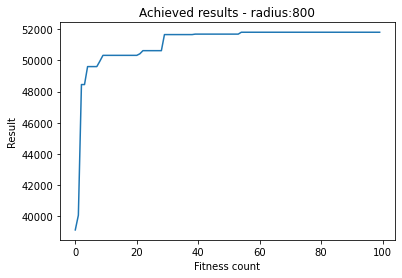

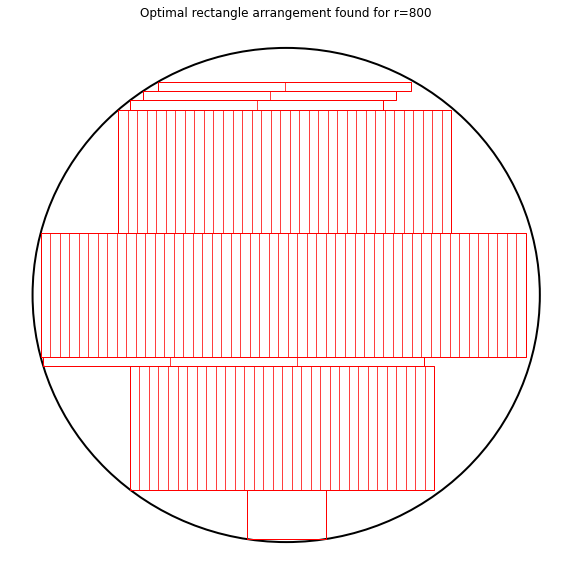

In [80]:
print("minimum expected result: 30000")
fit(full_dfs[0], 800)

minimum expected result: None
Selected rectangles: [13 12  9  6  6  6 10 13]
Result: 528100.0


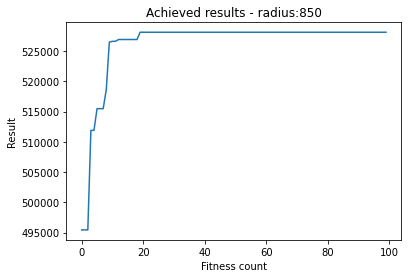

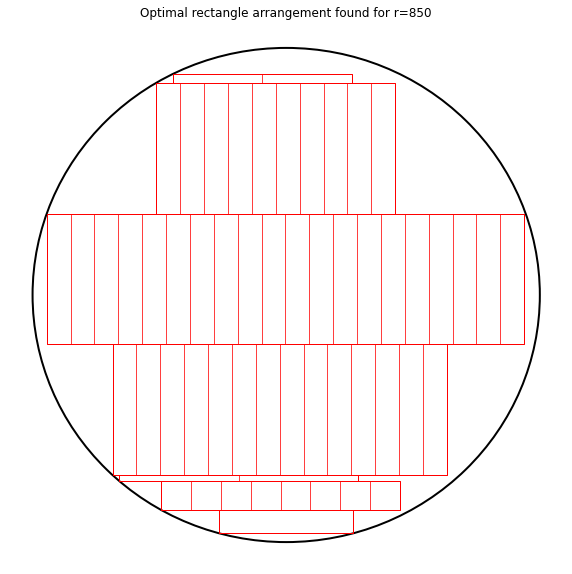

In [81]:
print("minimum expected result: None")
fit(full_dfs[1], 850)

minimum expected result: 17500
Selected rectangles: [5 6 2 6 2 6 2 2 2]
Result: 32300.0


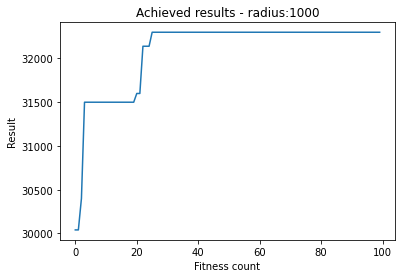

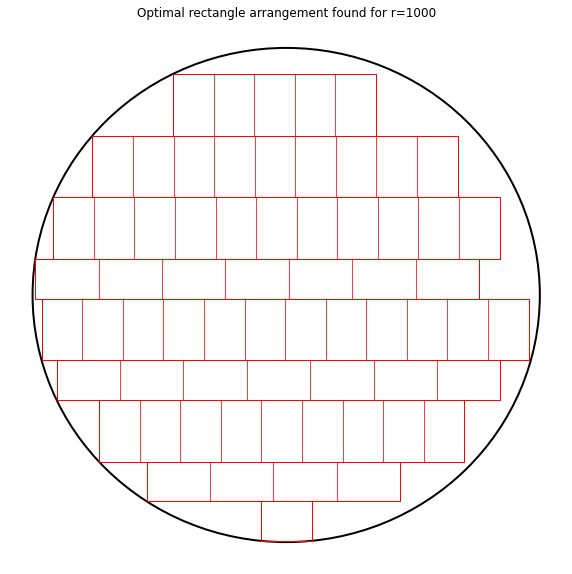

In [82]:
print("minimum expected result: 17500")
fit(full_dfs[2], 1000)

minimum expected result: 25000
Selected rectangles: [3 6 6 6 2 2 2 6 2 6 6]
Result: 48640.0


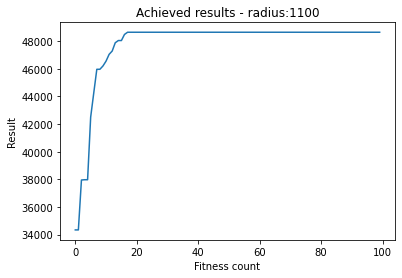

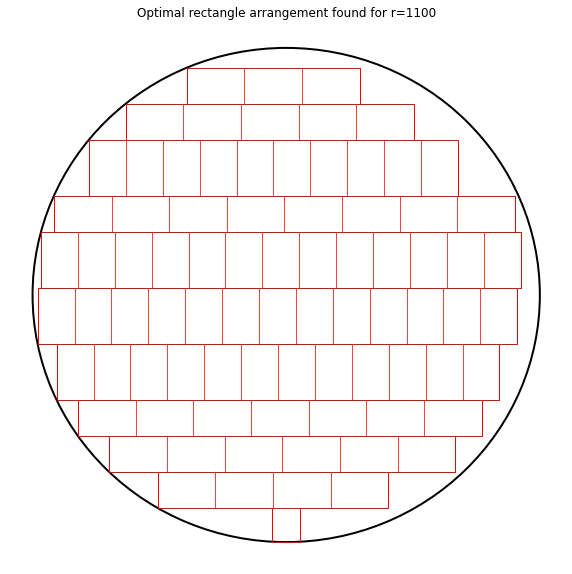

In [84]:
print("minimum expected result: 25000")
fit(full_dfs[3], 1100)

minimum expected result: 30000
Selected rectangles: [4 4 2 2 6 6 6 6 6 2 6 6 6 3]
Result: 48860.0


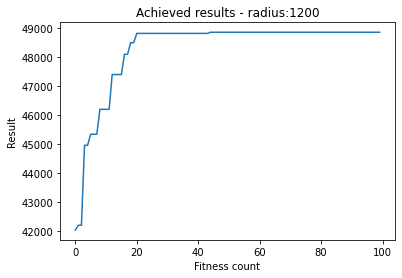

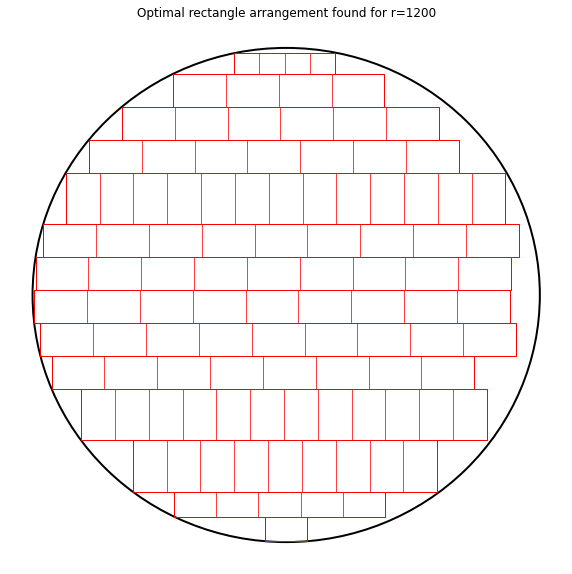

In [85]:
print("minimum expected result: 30000")
fit(full_dfs[4], 1200)